In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import fredapi

In [2]:
# Initialize FRED API
api_key = 'your_api_key'
fred = fredapi.Fred(api_key=api_key)

### Gathering data and plotting

In [3]:
def plot_time_series(df, value_col, title='Time Series Plot', xlabel='Date', ylabel='Value', figsize=(6, 4)):
    """
    Plots a time series from a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the time series data.
        value_col (str): Name of the column with the values to plot.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        figsize (tuple): Size of the figure.
    """
    # Plotting
    plt.figure(figsize=figsize)
    plt.plot(df.index, df[value_col], marker='o', linestyle='-', color='b')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Show plot
    plt.show()

In [4]:
start_date = '2006-01-01'

# Define the FRED series codes for each indicator
series_codes = {
    'CPI': 'CPIAUCSL',    # Consumer Price Index
    'NFP': 'PAYEMS',      # Nonfarm Payroll Employment
    'IP': 'INDPRO',       # Industrial Production Index
    'RSALES': 'CMRMTSPL', # Real Manufacturing and Trade Sales
    'RINC': 'W875RX1',    # Real Personal Income
    'RGDP': 'GDPC1',      # Real GDP (Quarterly)
    'IJC': 'ICSA',        # Initial Unemployment Claims (Weekly)
    'USD': 'DTWEXBGS'     # Nominal Broad U.S. Dollar Index (Daily)
}

In [5]:
# Fetch data
data = {key: fred.get_series(code, start_date) for key, code in series_codes.items()}

# Convert to DataFrame
data_dfs = {key: pd.DataFrame(value, columns=[key]) for key, value in data.items()}

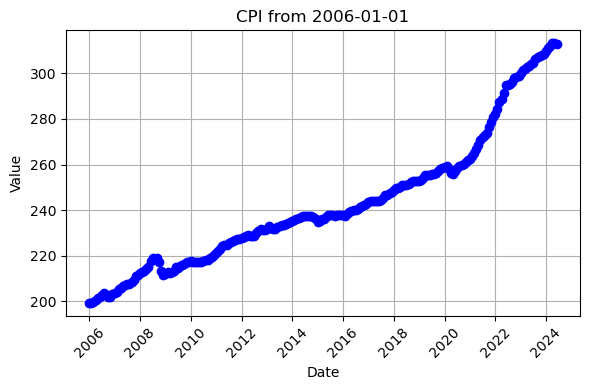

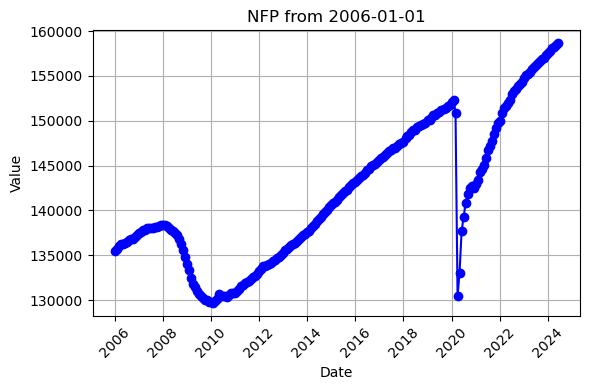

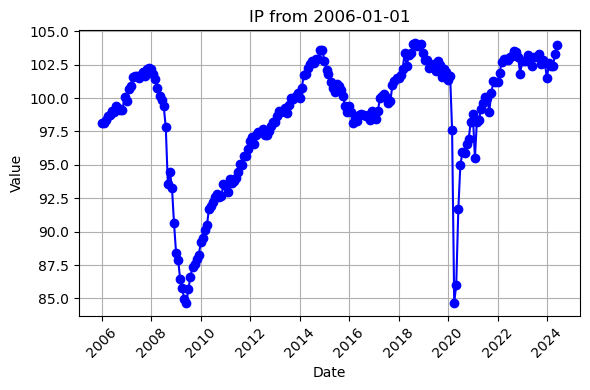

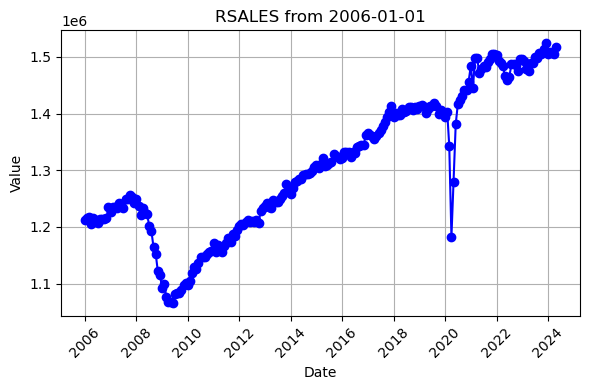

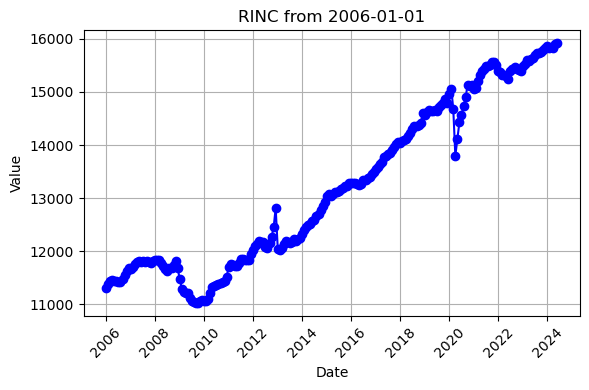

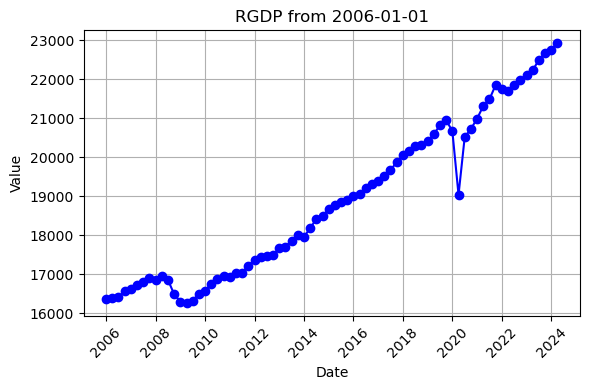

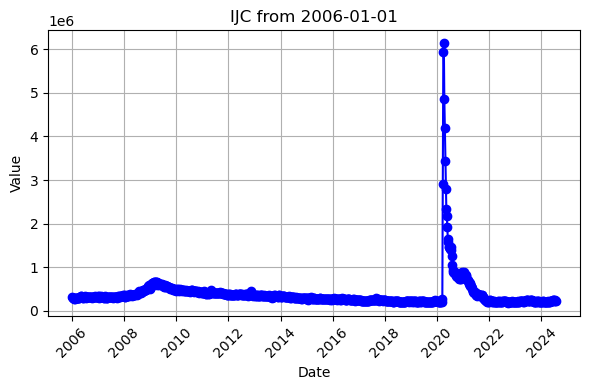

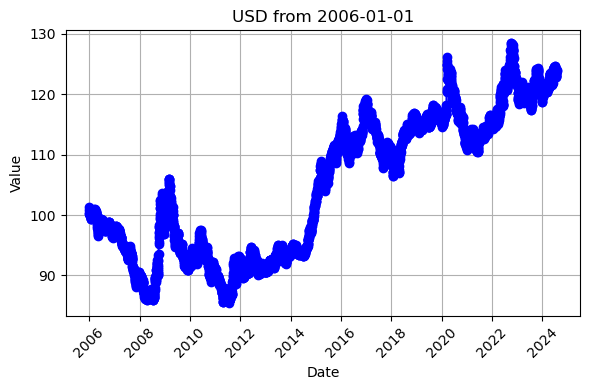

In [6]:
# Plot each indicator
for key, df in data_dfs.items():
    plot_time_series(data_dfs[key], key, title=f'{key} from 2006-01-01')

## First Approach

### Categorize and Binning

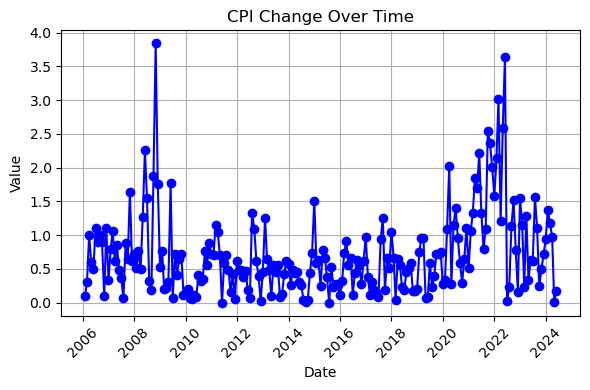

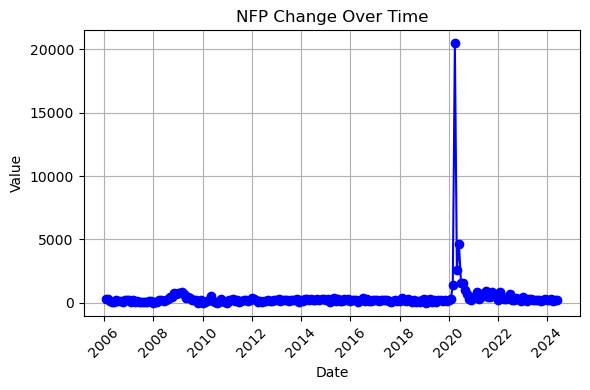

In [7]:
# Calculate absolute changes for CPI and NFP
data_dfs['CPI']['CPI_Change'] = data_dfs['CPI']['CPI'].diff().abs()
data_dfs['NFP']['NFP_Change'] = data_dfs['NFP']['NFP'].diff().abs()

plot_time_series(data_dfs['CPI'], 'CPI_Change', title='CPI Change Over Time')
plot_time_series(data_dfs['NFP'], 'NFP_Change', title='NFP Change Over Time')

In [8]:
def adaptive_binning(row, rolling_mean, rolling_std, index_name):
    mean = rolling_mean[row.name] # specific date
    std = rolling_std[row.name]
    change = row[index_name + '_Change']
    
    if pd.isna(mean) or pd.isna(std):
        return None  # Handle NaNs for initial rolling windows
    
    if change <= mean - std:
        return 0  # Normal
    elif change <= mean:
        return 1  # Medium
    elif change <= mean + std:
        return 2  # High
    else:
        return 3  # Extremely High

In [9]:
# Adaptive binning using rolling window
window_size = 30 

rolling_mean = data_dfs['CPI']['CPI_Change'].rolling(window=window_size).mean()
rolling_std = data_dfs['CPI']['CPI_Change'].rolling(window=window_size).std()

data_dfs['CPI']['CPI_bin'] = data_dfs['CPI'].apply(adaptive_binning, rolling_mean=rolling_mean, rolling_std=rolling_std, index_name='CPI', axis=1)


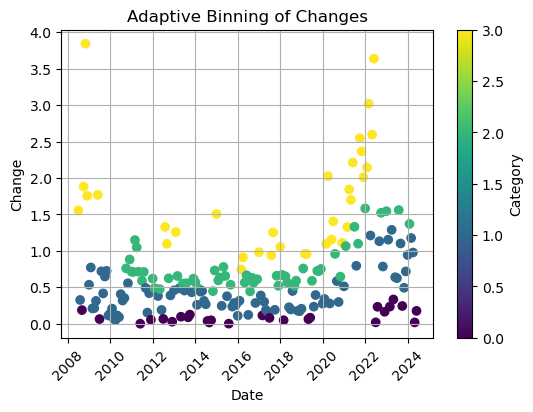

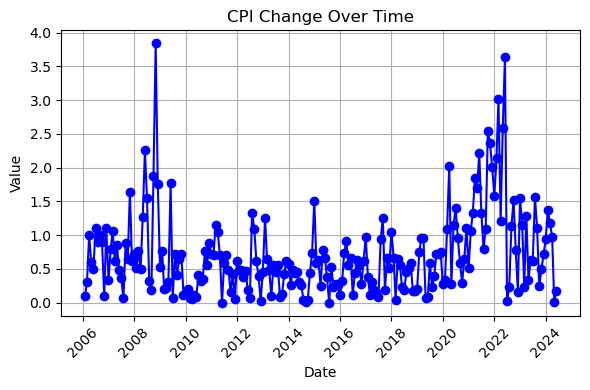

In [10]:
plt.figure(figsize=(6, 4))
plt.scatter(data_dfs['CPI'].index, data_dfs['CPI']['CPI_Change'], 
            c=data_dfs['CPI']['CPI_bin'], cmap='viridis', label='Bin')
plt.colorbar(label='Category')
plt.title('Adaptive Binning of Changes')
plt.xlabel('Date')
plt.ylabel('Change')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plot_time_series(data_dfs['CPI'], 'CPI_Change', title='CPI Change Over Time')

In [11]:
# Adaptive binning using rolling window
window_size = 30  

rolling_mean = data_dfs['NFP']['NFP_Change'].rolling(window=window_size).mean()
rolling_std = data_dfs['NFP']['NFP_Change'].rolling(window=window_size).std()

data_dfs['NFP']['NFP_bin'] = data_dfs['NFP'].apply(adaptive_binning, rolling_mean=rolling_mean, rolling_std=rolling_std, index_name='NFP', axis=1)

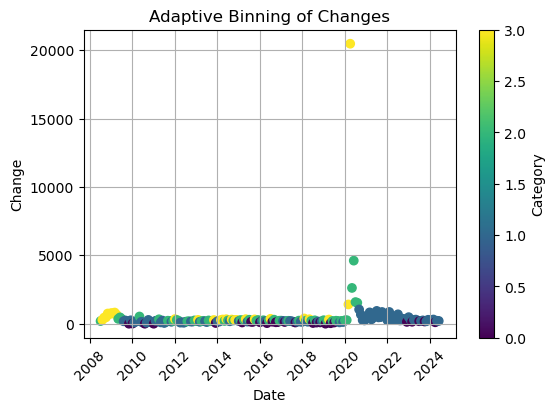

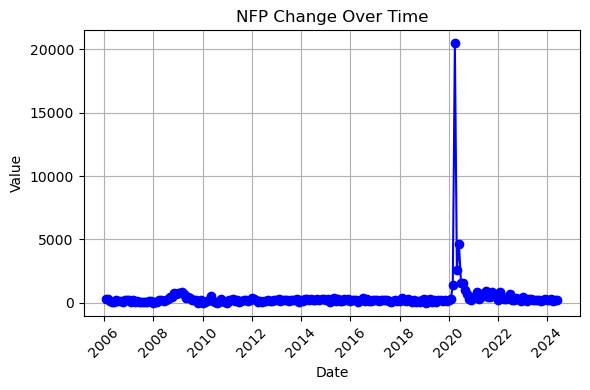

In [12]:
plt.figure(figsize=(6, 4))
plt.scatter(data_dfs['NFP'].index, data_dfs['NFP']['NFP_Change'], 
            c=data_dfs['NFP']['NFP_bin'], cmap='viridis', label='Bin')
plt.colorbar(label='Category')
plt.title('Adaptive Binning of Changes')
plt.xlabel('Date')
plt.ylabel('Change')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plot_time_series(data_dfs['NFP'], 'NFP_Change', title='NFP Change Over Time')

### USD Volatility

In [18]:
data_dfs['USD']['return'] = data_dfs['USD'].pct_change()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_172\1541678620.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data_dfs['USD']['return'] = data_dfs['USD'].pct_change()


In [19]:
# Volatility calculation
window = 30  

# Calculate rolling standard deviation of daily returns to get volatility
data_dfs['USD']['USD_Volatility'] = data_dfs['USD']['return'].rolling(window=window).std()

data_dfs['USD'].dropna(subset=['USD_Volatility'], inplace=True)

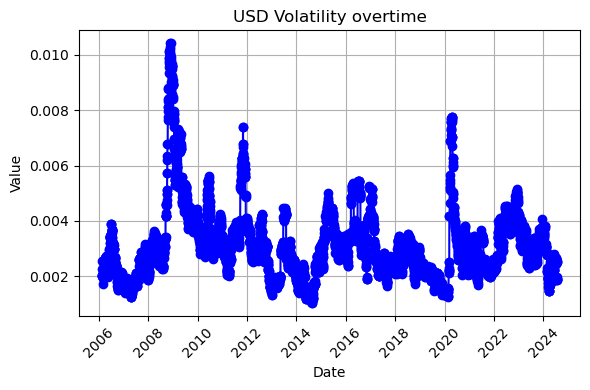

In [20]:
plot_time_series(data_dfs['USD'], 'USD_Volatility', title='USD Volatility overtime')

In [21]:
data_dfs['NFP']['NFP_lag1'] = data_dfs['NFP']['NFP_bin'].shift(1)

# reindex to USD index
data_dfs['NFP'] = data_dfs['NFP'].reindex(data_dfs['USD'].index, method='ffill')

data_dfs['NFP']

,NFP,NFP_Change,NFP_bin,NFP_lag1
2006-02-13,135732.0,307.0,NaN,NaN
2006-02-14,135732.0,307.0,NaN,NaN
2006-02-15,135732.0,307.0,NaN,NaN
2006-02-16,135732.0,307.0,NaN,NaN
2006-02-17,135732.0,307.0,NaN,NaN
...,...,...,...,...
2024-07-22,158638.0,206.0,1.0,1.0
2024-07-23,158638.0,206.0,1.0,1.0
2024-07-24,158638.0,206.0,1.0,1.0
2024-07-25,158638.0,206.0,1.0,1.0


In [22]:
usd_nfp = pd.merge(data_dfs['USD'], data_dfs['NFP'][['NFP_lag1']], left_index=True, right_index=True, how='left')

usd_nfp.dropna(inplace=True)

usd_nfp

,USD,return,USD_Volatility,NFP_lag1
2008-07-02,86.4782,-0.004220,0.002684,2.0
2008-07-03,86.8843,0.004696,0.002794,2.0
2008-07-04,86.8781,-0.000071,0.002775,2.0
2008-07-07,86.9617,0.000962,0.002778,2.0
2008-07-08,86.9778,0.000185,0.002732,2.0
...,...,...,...,...
2024-07-22,123.5735,0.000568,0.001887,1.0
2024-07-23,123.7296,0.001263,0.001894,1.0
2024-07-24,123.8784,0.001203,0.001888,1.0
2024-07-25,123.8341,-0.000358,0.001865,1.0


In [23]:
# Calculate rolling mean and standard deviation of volatility
window = 30  
usd_nfp['Rolling_Mean'] = usd_nfp['USD_Volatility'].rolling(window=window).mean()
usd_nfp['Rolling_Std'] = usd_nfp['USD_Volatility'].rolling(window=window).std()

# Calculate rolling confidence interval
usd_nfp['Lower_bound'] = usd_nfp['Rolling_Mean'] - 2 * usd_nfp['Rolling_Std']
usd_nfp['Upper_bound'] = usd_nfp['Rolling_Mean'] - 2 * usd_nfp['Rolling_Std']

# Detect outliers
usd_nfp['Outlier'] = (usd_nfp['USD_Volatility'] > usd_nfp['Upper_bound']) | (usd_nfp['USD_Volatility'] < usd_nfp['Lower_bound'])

usd_nfp['Outlier'].sum() # Numbers outliers

3976

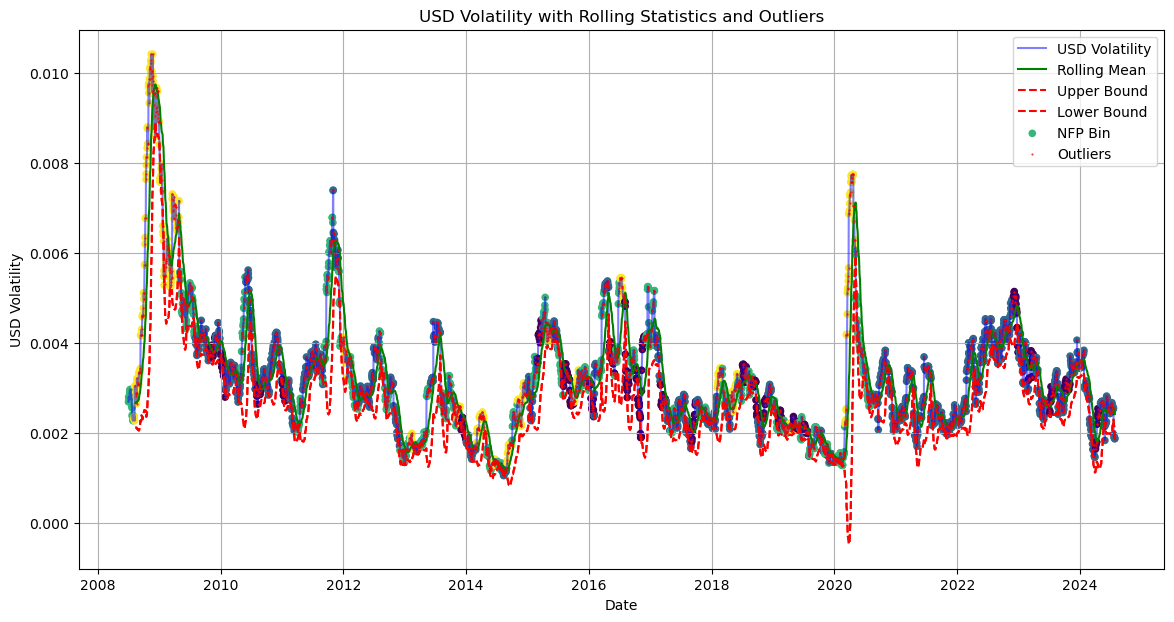

In [24]:
# Plot rolling mean, std, and outliers
plt.figure(figsize=(14, 7))
plt.plot(usd_nfp.index, usd_nfp['USD_Volatility'], label='USD Volatility', color='blue', alpha=0.5)
plt.plot(usd_nfp.index, usd_nfp['Rolling_Mean'], label='Rolling Mean', color='green')
plt.plot(usd_nfp.index, usd_nfp['Upper_bound'], label='Upper Bound', color='red', linestyle='--')
plt.plot(usd_nfp.index, usd_nfp['Lower_bound'], label='Lower Bound', color='red', linestyle='--')
plt.scatter(usd_nfp.index, usd_nfp['USD_Volatility'], c=usd_nfp['NFP_lag1'], cmap='viridis', s=20, label='NFP Bin')  
plt.scatter(usd_nfp.index[usd_nfp['Outlier']], usd_nfp['USD_Volatility'][usd_nfp['Outlier']], color='red', s=0.2, label='Outliers', zorder=5)  
plt.title('USD Volatility with Rolling Statistics and Outliers')
plt.xlabel('Date')
plt.ylabel('USD Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
data_dfs['CPI']['CPI_lag1'] = data_dfs['CPI']['CPI_bin'].shift(1)

# reindex to USD index
data_dfs['CPI'] = data_dfs['CPI'].reindex(data_dfs['USD'].index, method='ffill')

usd_cpi = pd.merge(data_dfs['USD'], data_dfs['CPI'][['CPI_lag1']], left_index=True, right_index=True, how='left')

usd_cpi.dropna(inplace=True)

In [29]:
# Calculate rolling mean and standard deviation of volatility
window = 30  
usd_cpi['Rolling_Mean'] = usd_cpi['USD_Volatility'].rolling(window=window).mean()
usd_cpi['Rolling_Std'] = usd_cpi['USD_Volatility'].rolling(window=window).std()

# Calculate rolling confidence interval
usd_cpi['Lower_bound'] = usd_cpi['Rolling_Mean'] - 2 * usd_cpi['Rolling_Std']
usd_cpi['Upper_bound'] = usd_cpi['Rolling_Mean'] - 2 * usd_cpi['Rolling_Std']

# Detect outliers
usd_cpi['Outlier'] = (usd_cpi['USD_Volatility'] > usd_cpi['Upper_bound']) | (usd_cpi['USD_Volatility'] < usd_cpi['Lower_bound'])

usd_cpi['Outlier'].sum() # Numbers outliers

3954

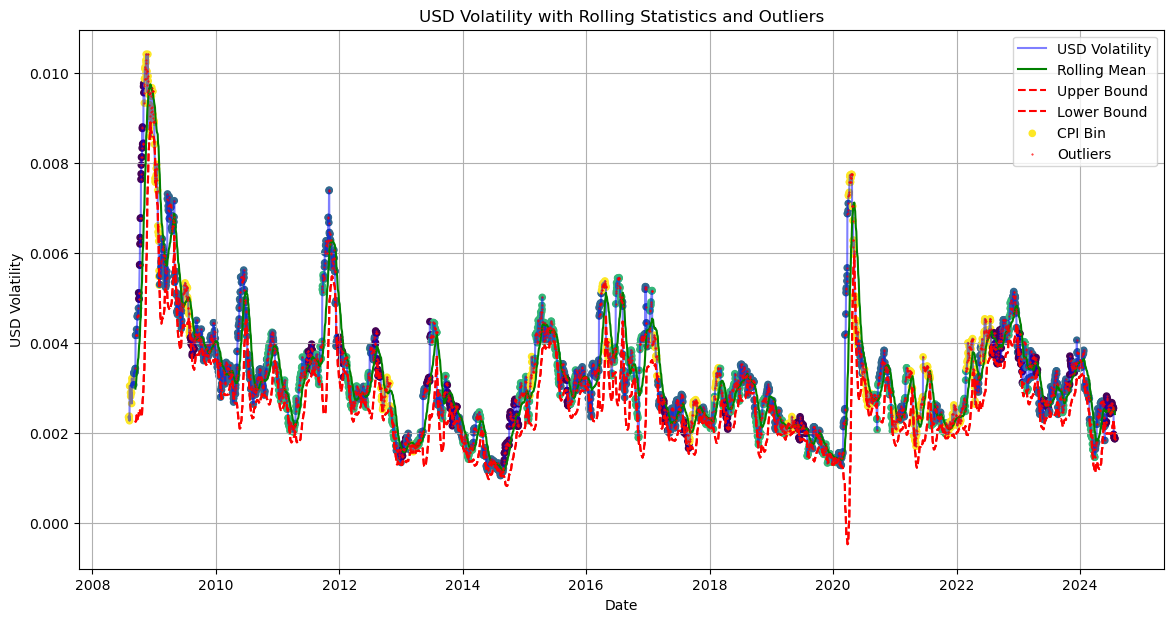

In [30]:
# Plot rolling mean, std, and outliers
plt.figure(figsize=(14, 7))
plt.plot(usd_cpi.index, usd_cpi['USD_Volatility'], label='USD Volatility', color='blue', alpha=0.5)
plt.plot(usd_cpi.index, usd_cpi['Rolling_Mean'], label='Rolling Mean', color='green')
plt.plot(usd_cpi.index, usd_cpi['Upper_bound'], label='Upper Bound', color='red', linestyle='--')
plt.plot(usd_cpi.index, usd_cpi['Lower_bound'], label='Lower Bound', color='red', linestyle='--')
plt.scatter(usd_cpi.index, usd_cpi['USD_Volatility'], c=usd_cpi['CPI_lag1'], cmap='viridis', s=20, label='CPI Bin')  
plt.scatter(usd_cpi.index[usd_cpi['Outlier']], usd_cpi['USD_Volatility'][usd_cpi['Outlier']], color='red', s=0.2, label='Outliers', zorder=5)  
plt.title('USD Volatility with Rolling Statistics and Outliers')
plt.xlabel('Date')
plt.ylabel('USD Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Calculate average volatility for each NFP bin
nfp_bin_volatility = usd_nfp.groupby('NFP_lag1')['USD_Volatility'].mean()
cpi_bin_volatility = usd_cpi.groupby('CPI_lag1')['USD_Volatility'].mean()

# Calculate overall average volatility
overall_volatility_nfp = usd_nfp['USD_Volatility'].mean()
overall_volatility_cpi = usd_cpi['USD_Volatility'].mean()

In [34]:
# Calculate relative impact for each NFP category
nfp_relative_impact = nfp_bin_volatility / overall_volatility_nfp

# Calculate relative impact for each CPI category
cpi_relative_impact = cpi_bin_volatility / overall_volatility_cpi

In [35]:
# Normalize the impacts to get weights
total_impact_nfp = nfp_relative_impact.sum()
total_impact_cpi = cpi_relative_impact.sum()

nfp_weight = nfp_relative_impact / total_impact_nfp
cpi_weight = cpi_relative_impact / total_impact_cpi

# Combine weights
weights = pd.DataFrame({
    'NFP_Weight': nfp_weight,
    'CPI_Weight': cpi_weight
}).fillna(0)

print(weights)

     NFP_Weight  CPI_Weight
0.0    0.223185    0.234706
1.0    0.226774    0.253726
2.0    0.226602    0.223810
3.0    0.323439    0.287758


In [42]:
merged_data = pd.merge(usd_nfp[['USD_Volatility', 'NFP_lag1']], usd_cpi[['CPI_lag1']], left_index=True, right_index=True, how='inner')
# Map categorical values to their relative impact
merged_data['Normalized_NFP'] = merged_data['NFP_lag1'].map(nfp_relative_impact)
merged_data['Normalized_CPI'] = merged_data['CPI_lag1'].map(cpi_relative_impact)

merged_data.head()

,USD_Volatility,NFP_lag1,CPI_lag1,Normalized_NFP,Normalized_CPI
2008-08-01,0.002344,2.0,3.0,0.946914,1.15857
2008-08-04,0.002302,3.0,3.0,1.351570,1.15857
2008-08-05,0.002307,3.0,3.0,1.351570,1.15857
2008-08-06,0.002366,3.0,3.0,1.351570,1.15857
2008-08-07,0.002264,3.0,3.0,1.351570,1.15857


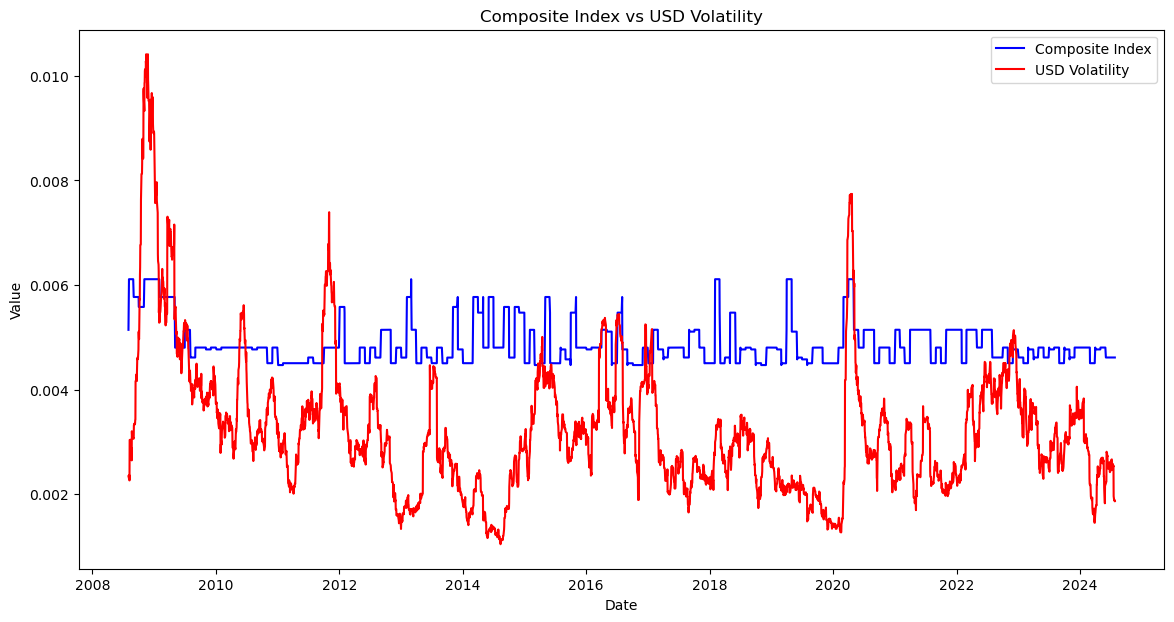

In [43]:
# Create composite index
merged_data['Composite_Index'] = (
    merged_data['NFP_lag1'].map(nfp_weight) +
    merged_data['CPI_lag1'].map(cpi_weight)
)

# Plot Composite Index and USD Volatility
plt.figure(figsize=(14, 7))
plt.plot(merged_data.index, merged_data['Composite_Index'] / 100.0, label='Composite Index', color='blue')
plt.plot(merged_data.index, merged_data['USD_Volatility'], label='USD Volatility', color='red')
plt.title('Composite Index vs USD Volatility')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


## Kalman Filter Approach

In [79]:
start_date = '2000-01-01'

# FRED series codes
series_codes = {
    'IP': 'INDPRO',       # Industrial Production Index
    'RSALES': 'CMRMTSPL', # Real Manufacturing and Trade Sales
    'RINC': 'W875RX1',    # Real Personal Income
    'RGDP': 'GDPC1',      # Real GDP (Quarterly)
    'IJC': 'ICSA',        # Initial Unemployment Claims (Weekly)
}

# Fetch data from FRED
data = {key: fred.get_series(code, start_date) for key, code in series_codes.items()}
df = pd.DataFrame(data)
df

,IP,RSALES,RINC,RGDP,IJC
2000-01-01,91.4092,1069375.0,10000.3,13878.147,286000.0
2000-01-08,NaN,NaN,NaN,NaN,298000.0
2000-01-15,NaN,NaN,NaN,NaN,289000.0
2000-01-22,NaN,NaN,NaN,NaN,284000.0
2000-01-29,NaN,NaN,NaN,NaN,285000.0
...,...,...,...,...,...
2024-06-22,NaN,NaN,NaN,NaN,234000.0
2024-06-29,NaN,NaN,NaN,NaN,239000.0
2024-07-06,NaN,NaN,NaN,NaN,223000.0
2024-07-13,NaN,NaN,NaN,NaN,245000.0


In [80]:
# Ensure DataFrame index is a datetime index and set frequency to daily
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')

# Interpolate missing values (use forward fill or another method if needed)
df = df.interpolate(method='linear')
df

,IP,RSALES,RINC,RGDP,IJC
2000-01-01,91.409200,1.069375e+06,10000.300000,13878.147000,286000.000000
2000-01-02,91.419371,1.068754e+06,10001.770968,13880.924593,287714.285714
2000-01-03,91.429542,1.068134e+06,10003.241935,13883.702187,289428.571429
2000-01-04,91.439713,1.067513e+06,10004.712903,13886.479780,291142.857143
2000-01-05,91.449884,1.066892e+06,10006.183871,13889.257374,292857.142857
...,...,...,...,...,...
2024-07-16,103.994100,1.517365e+06,15916.400000,22918.739000,240714.285714
2024-07-17,103.994100,1.517365e+06,15916.400000,22918.739000,239285.714286
2024-07-18,103.994100,1.517365e+06,15916.400000,22918.739000,237857.142857
2024-07-19,103.994100,1.517365e+06,15916.400000,22918.739000,236428.571429


In [81]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df_normalized

,IP,RSALES,RINC,RGDP,IJC
2000-01-01,0.346623,0.079141,0.000000,0.000000,0.016639
2000-01-02,0.347146,0.077884,0.000249,0.000307,0.016927
2000-01-03,0.347670,0.076626,0.000497,0.000614,0.017215
2000-01-04,0.348193,0.075369,0.000746,0.000922,0.017503
2000-01-05,0.348717,0.074111,0.000995,0.001229,0.017791
...,...,...,...,...,...
2024-07-16,0.994354,0.986575,1.000000,1.000000,0.009028
2024-07-17,0.994354,0.986575,1.000000,1.000000,0.008788
2024-07-18,0.994354,0.986575,1.000000,1.000000,0.008547
2024-07-19,0.994354,0.986575,1.000000,1.000000,0.008307


In [82]:
# Kalman Filter Parameters
n = len(df_normalized)  # Number of observations
m = len(series_codes)  # Number of indicators

# State transition matrix (identity matrix for simplicity)
F = np.eye(m)

# Measurement matrix (identity matrix)
H = np.eye(m)

# Process noise covariance
Q = np.eye(m) * 0.001

# Measurement noise covariance
R = np.eye(m) * 0.01

# Initial estimate covariance
P = np.eye(m)

# Initial state estimate
x = np.zeros((m, 1))

In [83]:
# Kalman Filter Algorithm
estimates = np.zeros((n, m))

for t in range(n):
    z = df_normalized.iloc[t].values.reshape(-1, 1)  # Measurement vector
    
    # Prediction step
    x = F @ x
    P = F @ P @ F.T + Q
    
    # Update step
    K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)
    x = x + K @ (z - H @ x)
    P = (np.eye(m) - K @ H) @ P
    
    estimates[t, :] = x.flatten()

# Create Composite Index
df_normalized['Composite_Index'] = estimates.mean(axis=1)


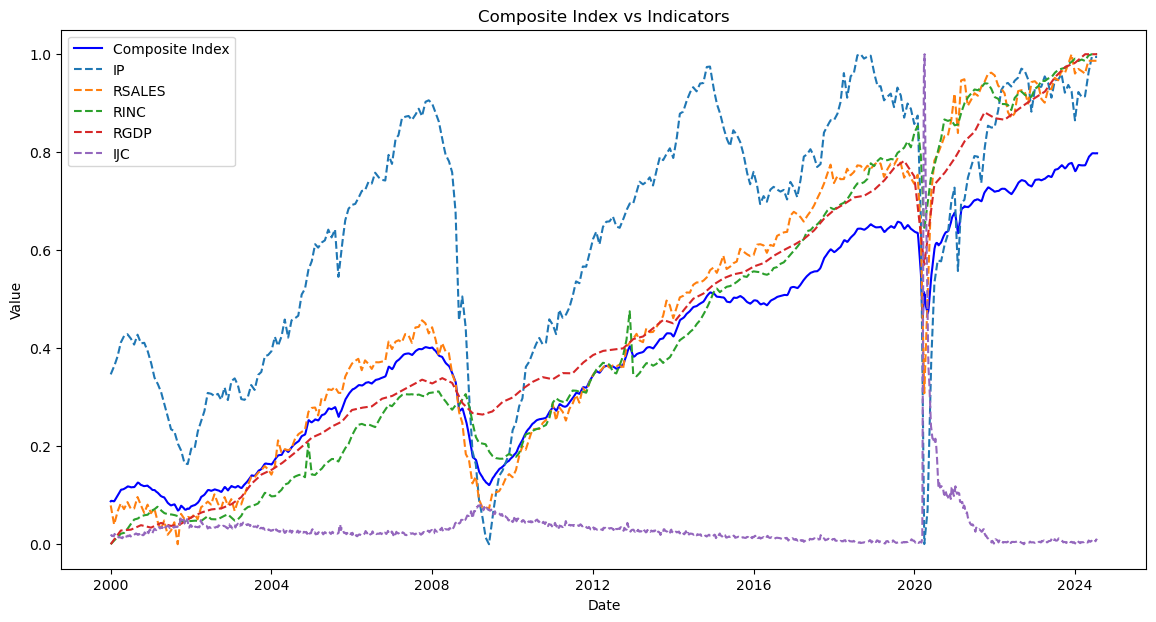

In [84]:
# Plot Composite Index and Indicators
plt.figure(figsize=(14, 7))
plt.plot(df_normalized.index, df_normalized['Composite_Index'], label='Composite Index', color='blue')

for col in series_codes.keys():
    plt.plot(df_normalized.index, df_normalized[col], label=col, linestyle='--')

plt.title('Composite Index vs Indicators')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()
